In [50]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
train = pd.read_csv('data/News_Train.csv')
test = pd.read_csv('data/News_Test.csv')
X_train = train.loc[:,train.columns != 'shares']
y_train = train.loc[:,train.columns == 'shares']

In [52]:
train.corr()['shares'].sort_values(ascending=False)

shares                           1.000000
kw_avg_avg                       0.107429
num_imgs                         0.090645
kw_max_avg                       0.079531
kw_min_avg                       0.077779
LDA_03                           0.075461
num_hrefs                        0.072622
global_subjectivity              0.064016
abs_title_sentiment_polarity     0.047195
kw_max_min                       0.041228
global_rate_negative_words       0.037965
kw_min_max                       0.037648
num_self_hrefs                   0.035308
kw_avg_min                       0.034295
self_reference_avg_sharess       0.029220
self_reference_max_shares        0.028921
avg_positive_polarity            0.028890
num_videos                       0.028749
rate_negative_words              0.028205
kw_avg_max                       0.023130
self_reference_min_shares        0.023078
weekday_is_sunday                0.021041
n_tokens_content                 0.019353
kw_min_min                       0

In [53]:
class FeatureSelector(BaseEstimator, TransformerMixin ):
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [92]:
class CustomTransformer(BaseEstimator, TransformerMixin ):
    def __init__( self ):
        pass
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        kw_shares = X.apply(lambda row: row['kw_avg_min']+row['kw_avg_max']+row['kw_avg_avg'],axis=1)
        return X.assign(kw_shares=kw_shares)

In [127]:
def save(model):
    model.fit(X_train,y_train)
    pred = model.predict(test)
    pd.DataFrame(pred,columns=['shares']).to_csv('data/submission.csv',index=False)

def eval_score(model):
    model.fit(X_train,y_train)
    y_pred =model.predict(X_train)
    print(mean_absolute_error(y_train,y_pred))
    
def cross_score(pipeline, model):
    transformed = pipeline.transform(X_train)
    scores = cross_val_score(model,transformed,y_train,cv=5,scoring='neg_mean_absolute_error')
    print(scores.mean())

<BarContainer object of 58 artists>

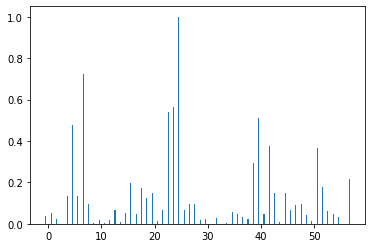

In [56]:
selector = SelectKBest(f_regression, k='all')
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(X_train.shape[-1])
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

In [57]:
feature_map = pd.DataFrame(zip(X_train.columns,selector.pvalues_),columns=['feature','score'])
features = feature_map[feature_map['score'] < 0.05]['feature']
features

4         n_non_stop_unique_tokens
5                        num_hrefs
6                   num_self_hrefs
7                         num_imgs
8                       num_videos
13             data_channel_is_bus
16           data_channel_is_world
18                      kw_max_min
19                      kw_avg_min
20                      kw_min_max
22                      kw_avg_max
23                      kw_min_avg
24                      kw_max_avg
25                      kw_avg_avg
26       self_reference_min_shares
27       self_reference_max_shares
28      self_reference_avg_sharess
39                          LDA_02
40                          LDA_03
42             global_subjectivity
43       global_sentiment_polarity
45      global_rate_negative_words
46             rate_positive_words
47             rate_negative_words
48           avg_positive_polarity
51           avg_negative_polarity
52           min_negative_polarity
53           max_negative_polarity
57    abs_title_sent

In [82]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat))
selected_feat

19


Index(['n_tokens_content', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_imgs',
       'average_token_length', 'num_keywords', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_avg_sharess', 'LDA_01',
       'global_subjectivity', 'global_sentiment_polarity',
       'rate_positive_words'],
      dtype='object')

In [97]:
columns =['n_tokens_content', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_imgs',
       'average_token_length', 'num_keywords', 'kw_shares', 'self_reference_avg_sharess', 'LDA_01',
       'global_subjectivity', 'global_sentiment_polarity',
       'rate_positive_words']

In [140]:
columns =['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity']

In [139]:
train.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

In [141]:
boost = xgb.XGBRegressor(
    n_jobs=-1,
    max_depth =10,
    n_estimators=1000,
    learning_rate=0.05,
    reg_alpha=0.5,
    gamma=0.2,
    reg_lambda=0.1)

In [142]:
boost_pipeline = make_pipeline(CustomTransformer(),FeatureSelector(columns),boost)
eval_score(boost_pipeline)

75.57211265452094


In [143]:
cross_score(make_pipeline(CustomTransformer(),FeatureSelector(columns)),boost)

-8469.60484581304


In [118]:
save(boost_pipeline)

In [136]:
gbm = lgb.LGBMRegressor(
                        num_leaves=1023,
                        learning_rate=0.3,
                        num_iterations=1000 
                        )

In [137]:
gbm_pipeline = make_pipeline(CustomTransformer(),FeatureSelector(columns),gbm)
eval_score(gbm_pipeline)

18.502538195120877


In [138]:
cross_score(make_pipeline(CustomTransformer(),FeatureSelector(columns)),gbm)

-11692.072913797942
